<a href="https://colab.research.google.com/github/ajeet0001/machine-learning-project-/blob/main/EEG_Cognitive_State_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1) Install required packages
!pip install mne==1.4.0 pyedflib==0.1.29 scikit-learn xgboost imbalanced-learn matplotlib seaborn --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
# 2) Download the PhysioNet EEGMAT dataset (EEG during mental arithmetic tasks)
# The dataset page: https://physionet.org/content/eegmat/1.0.0/  (open-access)
# We'll mirror the files into /content/eegmat
import os
DATA_DIR = "/content/eegmat"
os.makedirs(DATA_DIR, exist_ok=True)

# Use wget to download the dataset files recursively (as suggested by PhysioNet page)
# Note: this downloads ~175 MB
print("Downloading EEGMAT dataset (this may take a couple minutes)...")
!wget -r -N -c -np -nH --cut-dirs=3 -P {DATA_DIR} https://physionet.org/files/eegmat/1.0.0/

--2025-10-23 16:25:26--  https://physionet.org/files/eegmat/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/content/eegmat/index.html’

index.html              [ <=>                ]   9.11K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2025-10-23 16:25:26 (211 MB/s) - ‘/content/eegmat/index.html’ saved [9326]

Loading robots.txt; please ignore errors.
--2025-10-23 16:25:26--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: ‘/content/eegmat/robots.txt’

robots.txt          100%[===================>]      22  --.-KB/s    in 0s      

2025-10-23 16:25:26 (7.42 MB/s) - ‘/content/eegmat/robots.txt’ saved [22/22]

--2025-10-23 16:25:26--  https://physionet.org/fi

In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 50.8 MB/s eta 0:00:00


In [ ]:
# 3) Load libraries
import glob
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

print("Packages loaded.")

Packages loaded.


In [ ]:
# 4) Inspect downloaded files
edf_files = sorted(glob.glob(os.path.join(DATA_DIR, "Subject*_*.edf")))
print(f"Found {len(edf_files)} EDF files (examples):", edf_files[:6])

# There is also a subject-info.csv in the dataset; let's read it to get subject metadata
subj_info_path = os.path.join(DATA_DIR, "subject-info.csv")
if os.path.exists(subj_info_path):
    subj_info = pd.read_csv(subj_info_path)
    display(subj_info.head())
else:
    print("subject-info.csv not found in download folder. Proceeding without it.")

Found 72 EDF files (examples): ['/content/eegmat/Subject00_1.edf', '/content/eegmat/Subject00_2.edf', '/content/eegmat/Subject01_1.edf', '/content/eegmat/Subject01_2.edf', '/content/eegmat/Subject02_1.edf', '/content/eegmat/Subject02_2.edf']


,Subject,Age,Gender,Recording year,Number of subtractions,Count quality
0,Subject00,21,F,2011,9.70,0
1,Subject01,18,F,2011,29.35,1
2,Subject02,19,F,2012,12.88,1
3,Subject03,17,F,2010,31.00,1
4,Subject04,17,F,2010,8.60,0


In [ ]:
# 5) Helper functions: bandpower & windowing
from scipy.signal import welch

def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average band power of the signal x in a specific frequency band."""
    band = np.array(band)
    low, high = band
    if window_sec is None:
        nperseg = min(256, len(data))
    else:
        nperseg = int(window_sec * sf)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    # Frequency resolution may be coarse; integrate PSD in band
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    bp = np.trapz(psd[idx_band], freqs[idx_band])
    if relative:
        bp = bp / np.trapz(psd, freqs)
    return bp

def extract_features_from_raw(raw, sf=128, win_sec=4, bands=None):
    """
    raw: mne.Raw-like object (channels x samples)
    Returns a DataFrame of features per window
    """
    if bands is None:
        bands = {"delta": (1,4), "theta": (4,8), "alpha": (8,13), "beta": (13,30), "gamma": (30,45)}
    data = raw.get_data()  # shape (n_channels, n_times)
    n_channels, n_times = data.shape
    win_samples = int(win_sec * sf)
    n_windows = n_times // win_samples
    rows = []
    for w in range(n_windows):
        start = w * win_samples
        stop = start + win_samples
        window_data = data[:, start:stop]
        feat = {}
        # per-channel bandpowers (absolute) and simple stats (mean, var)
        for ch in range(n_channels):
            ch_data = window_data[ch, :]
            # time-domain stats
            feat[f"ch{ch}_mean"] = np.mean(ch_data)
            feat[f"ch{ch}_std"] = np.std(ch_data)
            feat[f"ch{ch}_rms"] = np.sqrt(np.mean(ch_data**2))
            # bandpowers
            for bname, bfreq in bands.items():
                bp = bandpower(ch_data, sf, bfreq, window_sec=win_sec, relative=False)
                feat[f"ch{ch}_{bname}_bp"] = bp
        rows.append(feat)
    df = pd.DataFrame(rows)
    return df



In [ ]:
# 6) Build dataset (features + labels)
# Labeling strategy:
# - files ending with *_1.edf : baseline (label 0, low mental workload)
# - files ending with *_2.edf : task (label 1, high mental workload)
sf_target = 128  # we'll resample to 128 Hz if necessary
win_sec = 4      # window length for features

all_features = []
all_labels = []
subject_ids = []

print("Processing EDF files and extracting features. This may take a few minutes...")

for filepath in edf_files:
    fname = os.path.basename(filepath)
    label = 0 if fname.endswith("_1.edf") else 1
    # read raw EDF with mne
    try:
        raw = mne.io.read_raw_edf(filepath, verbose=False)
    except Exception as e:
        print("Failed to read:", filepath, e)
        continue
    # pick EEG channels only (MNE generally loads channel names; we keep all)
    # resample if needed
    if raw.info['sfreq'] != sf_target:
        raw.resample(sf_target, npad="auto")
    # optional: apply bandpass filter for 1-45 Hz
    raw.filter(1.0, 45.0, fir_design='firwin', verbose=False)
    # extract features per window
    feat_df = extract_features_from_raw(raw, sf=int(raw.info['sfreq']), win_sec=win_sec)
    # add labels and subject id
    subj_id = fname.split('_')[0]  # e.g., "Subject00"
    feat_df['label'] = label
    feat_df['subject'] = subj_id
    all_features.append(feat_df)
    subject_ids.append(subj_id)

features_df = pd.concat(all_features, ignore_index=True)
print("Extracted features shape:", features_df.shape)
display(features_df.head())

Processing EDF files and extracting features. This may take a few minutes...
Extracted features shape: (2134, 170)


,ch0_mean,ch0_std,ch0_rms,ch0_delta_bp,ch0_theta_bp,ch0_alpha_bp,ch0_beta_bp,ch0_gamma_bp,ch1_mean,ch1_std,...,ch20_mean,ch20_std,ch20_rms,ch20_delta_bp,ch20_theta_bp,ch20_alpha_bp,ch20_beta_bp,ch20_gamma_bp,label,subject
0,2.013026e-07,0.000007,0.000007,8.045872e-12,4.870051e-12,1.293889e-11,7.389544e-12,9.964225e-13,-1.750916e-08,0.000009,...,-1.054463e-06,0.000124,0.000124,6.323272e-09,3.747610e-09,3.340833e-09,2.288975e-09,4.110510e-11,0,Subject00
1,2.928223e-07,0.000009,0.000009,1.215779e-11,6.901275e-12,3.948140e-11,1.618918e-11,1.079758e-12,3.712054e-07,0.000012,...,-1.867268e-06,0.000123,0.000123,6.042427e-09,3.915759e-09,3.380869e-09,2.529013e-09,5.083692e-11,0,Subject00
2,3.762112e-08,0.000009,0.000009,1.933675e-11,3.163614e-12,3.569392e-11,1.122719e-11,8.929736e-13,-1.104996e-08,0.000010,...,-1.430658e-06,0.000123,0.000123,6.207429e-09,3.216738e-09,3.425687e-09,2.447105e-09,4.805638e-11,0,Subject00
3,1.676632e-07,0.000010,0.000010,4.458243e-11,2.975803e-11,3.917507e-11,1.470153e-11,1.134346e-12,2.211694e-07,0.000011,...,-2.404911e-07,0.000125,0.000125,6.157615e-09,3.650397e-09,3.194604e-09,2.416250e-09,5.282147e-11,0,Subject00
4,-2.210322e-07,0.000009,0.000009,1.085197e-11,5.388433e-12,3.532745e-11,8.490447e-12,1.207088e-12,-5.275174e-08,0.000010,...,4.842822e-07,0.000126,0.000126,6.156375e-09,3.598011e-09,3.002085e-09,2.289041e-09,4.747901e-11,0,Subject00


In [ ]:
# 7) Prepare training data
X = features_df.drop(columns=['label', 'subject']).values
y = features_df['label'].values
subjects = features_df['subject'].values
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (2134, 168) y shape: (2134,)


In [ ]:
# 8) Train/Test split (subject-stratified is better; here use stratified by label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (1707, 168) Test size: (427, 168)


In [ ]:
# 9) Standardize features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [ ]:
# 10) Define classifiers
svm = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
models = {'SVM': svm, 'RandomForest': rf, 'XGBoost': xgb}

In [ ]:
# 11) Train & evaluate
results = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train_s, y_train)
    y_pred = model.predict(X_test_s)
    y_proba = model.predict_proba(X_test_s)[:,1]
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=4)
    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results[name] = {'model': model, 'accuracy': acc, 'report': report, 'cm': cm, 'auc': auc}
    print(f"{name} Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    print(report)


Training SVM ...
SVM Accuracy: 0.8689, AUC: 0.9344
              precision    recall  f1-score   support

           0     0.8623    0.9812    0.9179       319
           1     0.9062    0.5370    0.6744       108

    accuracy                         0.8689       427
   macro avg     0.8843    0.7591    0.7962       427
weighted avg     0.8734    0.8689    0.8563       427


Training RandomForest ...
RandomForest Accuracy: 0.9063, AUC: 0.9819
              precision    recall  f1-score   support

           0     0.8952    0.9906    0.9405       319
           1     0.9595    0.6574    0.7802       108

    accuracy                         0.9063       427
   macro avg     0.9273    0.8240    0.8603       427
weighted avg     0.9114    0.9063    0.8999       427


Training XGBoost ...
XGBoost Accuracy: 0.9532, AUC: 0.9922
              precision    recall  f1-score   support

           0     0.9517    0.9875    0.9692       319
           1     0.9583    0.8519    0.9020       108



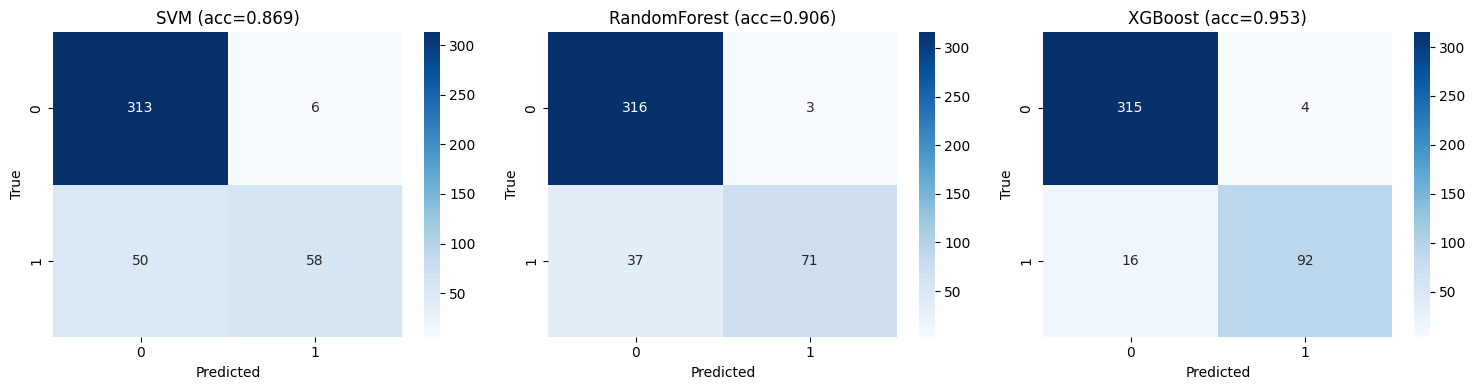

In [ ]:
# 12) Show confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, (name, res) in zip(axes.flatten(), results.items()):
    cm = res['cm']
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f"{name} (acc={res['accuracy']:.3f})")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

Best model by accuracy: XGBoost (acc=0.953, auc=0.992)


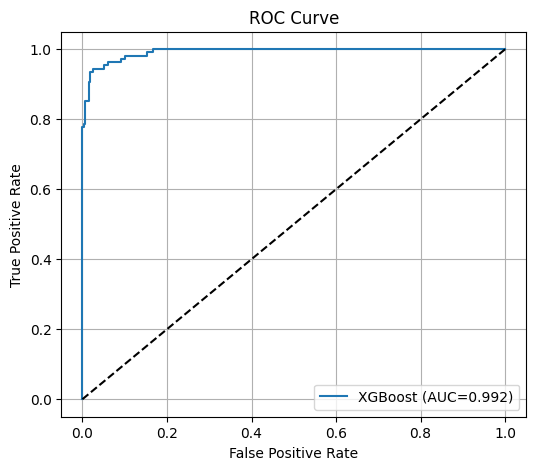

In [ ]:
# 13) ROC curve for best model (by accuracy)
best_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
best = results[best_name]
print(f"Best model by accuracy: {best_name} (acc={results[best_name]['accuracy']:.3f}, auc={results[best_name]['auc']:.3f})")

from sklearn.metrics import roc_curve
y_proba_best = best['model'].predict_proba(X_test_s)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'{best_name} (AUC={results[best_name]["auc"]:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 14) Save trained best model + scaler for later use
import joblib
joblib.dump(best['model'], '/content/best_eeg_model.pkl')
joblib.dump(scaler, '/content/feature_scaler.pkl')
print("Saved best model and scaler to /content")

Saved best model and scaler to /content
